In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import pyBigWig


In [2]:
def make_peak_tensor(promoterome_infile,peaks_infiles):
    # Make a boolean tensor of shape (N_prom,N_pos,N_exp)
    # where N_prom is the number of promoters, N_pos is the number of base pairs in the window, and N_exp is the number of experiments
    # The tensor is True if a peak is found in the promoterome

    # get promoterome
    promoterome = pd.read_csv(promoterome_infile,sep='\t')
    CHR = promoterome.chr.unique()

    # get peaks
    peaks_table = pd.DataFrame(columns=['exp_id','chr','start','end','score'])
    for infile in peaks_infiles:
        bb = pyBigWig.open(infile)
        id = infile.split('/')[-1].split('.')[0]
        for c in CHR:
            p = bb.entries(c,0,bb.chroms(c))
            p = pd.DataFrame(p,columns=['start','end','score'])
            p['chr'] = c
            p['exp_id'] = id
            peaks_table = pd.concat([peaks_table,p],axis=0)
    peaks_table = peaks_table.reset_index(drop=True)

    # overlap between peaks and promoterome
    N_prom = len(promoterome)
    N_pos = promoterome.at[0,'end'] - promoterome.at[0,'start']
    N_exp = len(peaks_infiles)
    TF_peaks = np.zeros([N_prom,N_pos,N_exp],dtype=bool) # tensor of shape (N_prom,N_pos,N_exp) X[i,j,k] is True if peak k is found in promoter i at position j
    
    exp_ids = np.array( [exp.split('/')[-1].split('.')[0] for exp in peaks_infiles] )
    x = promoterome.loc[:,['chr','start','end']].values
    for k, exp_id in enumerate(exp_ids):

        peak_idx = peaks_table[peaks_table.exp_id==exp_id].index
        y = peaks_table.loc[peak_idx,['chr','start','end']].values

        Prom_Peak_overlap = (x[:,0][:,None] == y[:,0][None,:]) & (x[:,1][:,None] <= y[:,2][None,:]) & (x[:,2][:,None] >= y[:,1][None,:])
        [idx_prom,idx_peak] = np.where(Prom_Peak_overlap)

        # Now fill in the tensor with the overlaping peaks
        for i,p in zip(idx_prom,idx_peak):
            o_start = peaks_table.loc[peak_idx[p],'start'] - promoterome.loc[i,'start']
            o_end = peaks_table.loc[peak_idx[p],'end'] - promoterome.loc[i,'start']
            j = range(max(o_start,0),min(o_end,N_pos))
            TF_peaks[i,j,k] = True

    return TF_peaks

4000

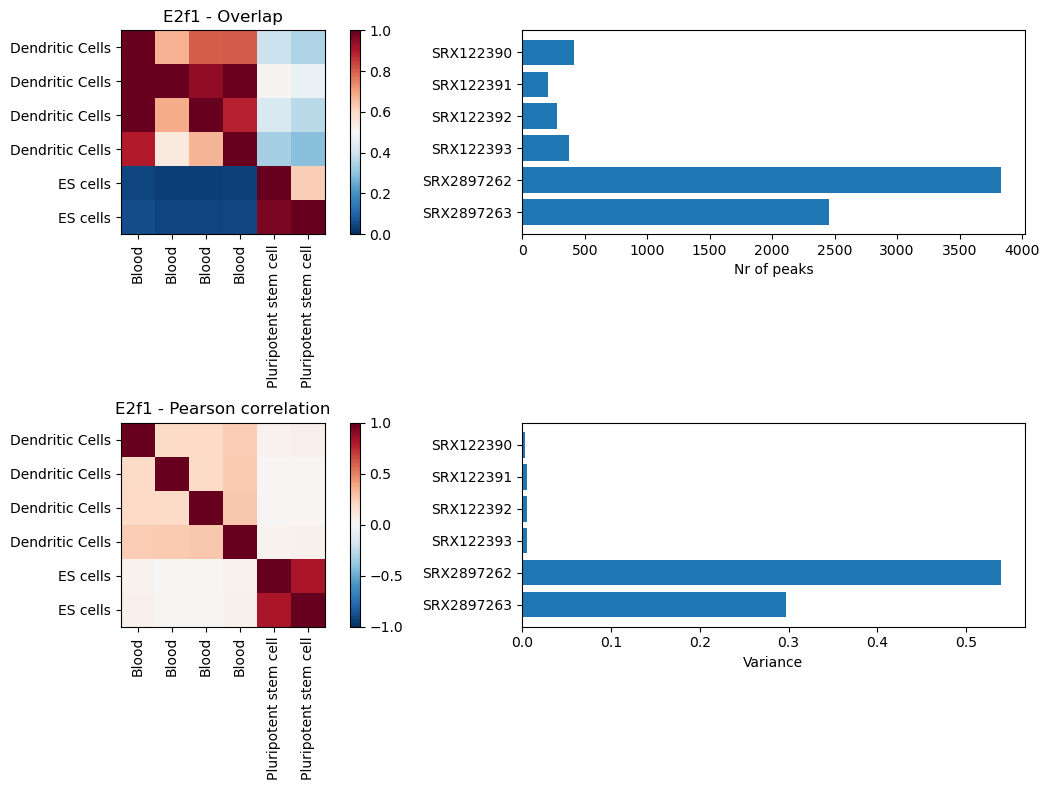

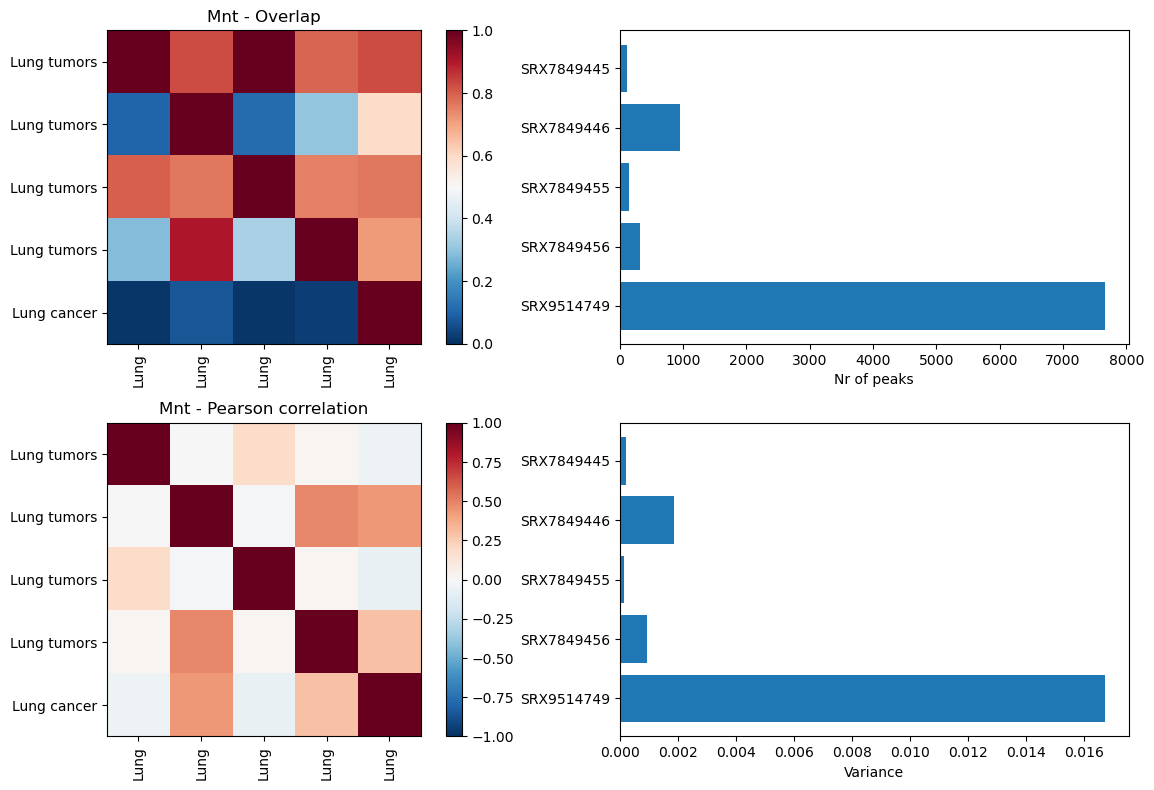

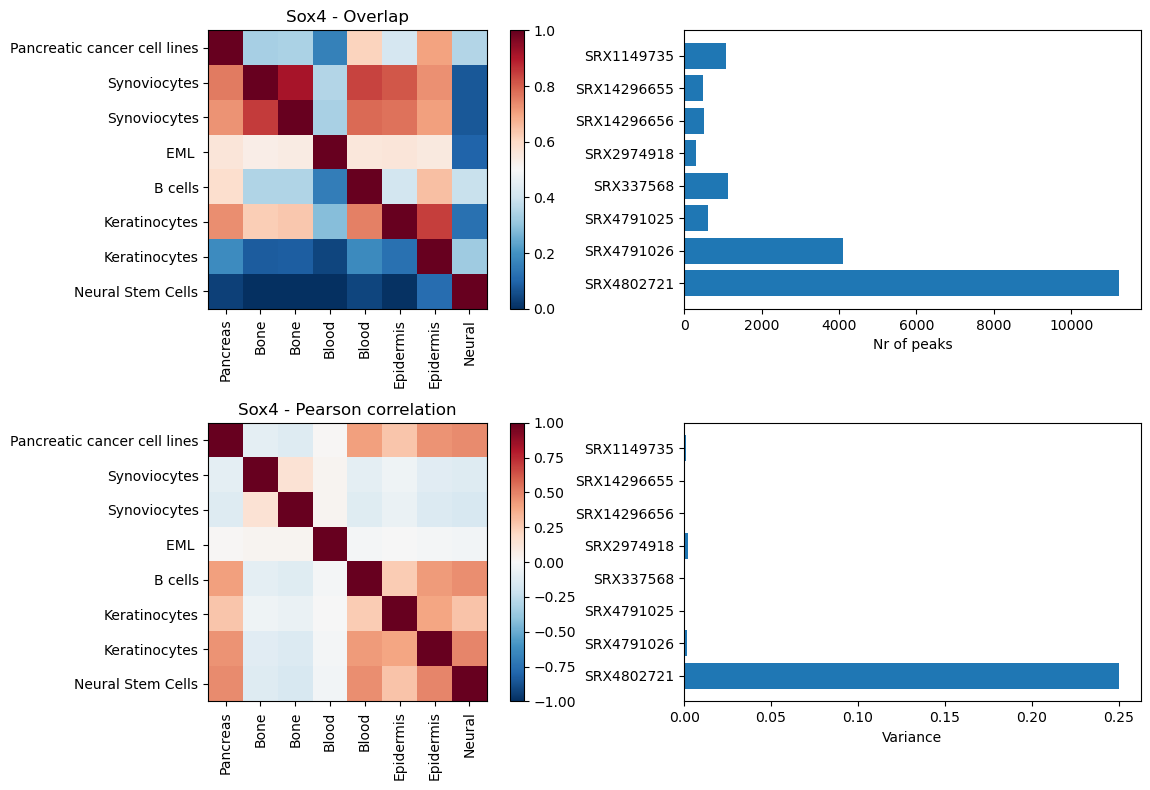

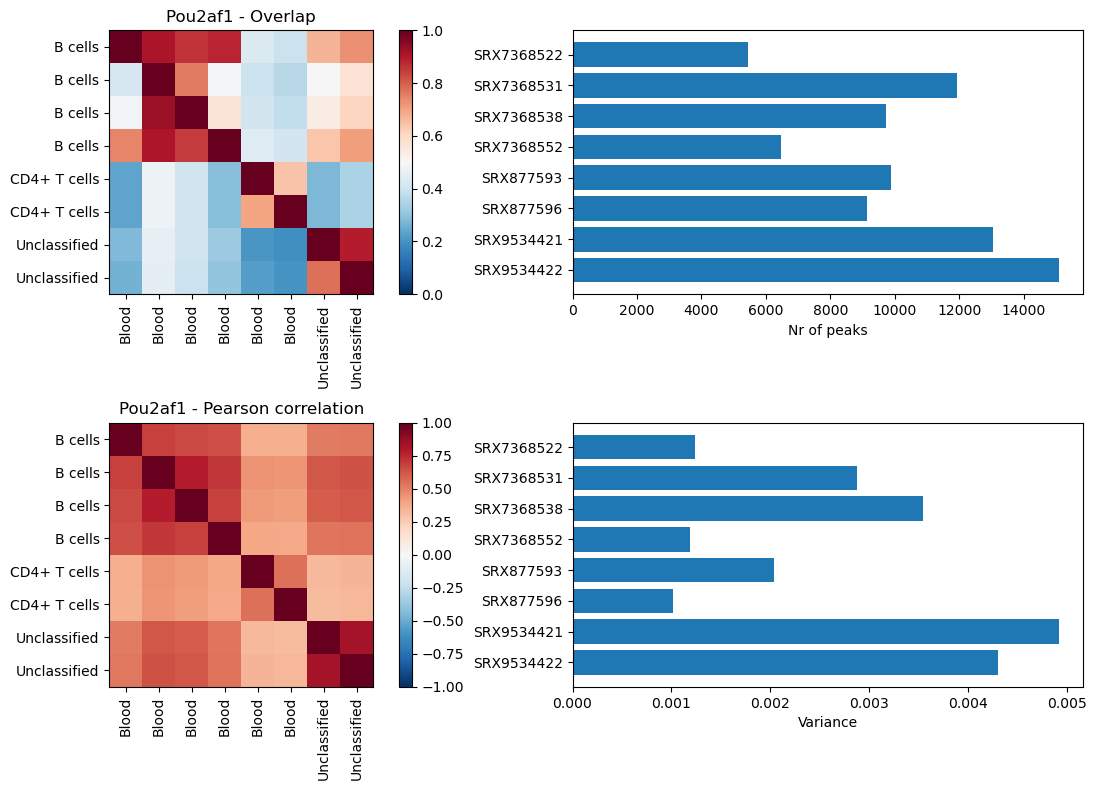

In [14]:
# parameters
genome = 'mm10'
size_factor = 100000
win = 1
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win}kb_filtered.bed"
promoterome = pd.read_csv(promoterome_infile,sep='\t')

for my_tf in TFs:
    # get TF tensor
    infile = f'../results/{genome}/TF_tensors/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        X = hf['chip_prom_pos_exp'][:]

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape

    X_flat = X.reshape([N_prom*N_pos,N_exp])

    # compute pearson corr.
    rho = np.corrcoef(X_flat.T)
    v = np.nanvar(X_flat,axis=0)
    m = np.nanmean(X_flat,axis=0)
    # Z score
    #X = ((X - m) / np.sqrt(v)) + m

    # average per cell type
    X_ct = np.zeros([N_prom*N_pos,len(my_celltype)])
    for i in np.unique(celltype_idx):
        X_ct[:,i] = np.mean(X_flat[:,celltype_idx==i],axis=1)

    # get peak-peak overlap
    # get peaks
    peaks_table = pd.DataFrame(columns=['exp_id','chr','start','end','score'])
    peak_infiles = [f'../resources/tracks/{genome}/{id}.05.bb' for id in my_ids]
    for infile in peak_infiles:
        bb = pyBigWig.open(infile)
        id = infile.split('/')[-1].split('.')[0]
        for c in CHR:
            p = bb.entries(c,0,bb.chroms(c))
            p = pd.DataFrame(p,columns=['start','end','score'])
            p['chr'] = c
            p['exp_id'] = id
            peaks_table = pd.concat([peaks_table,p],axis=0)
    peaks_table = peaks_table.reset_index(drop=True)

    N_peaks = peaks_table['exp_id'].value_counts() # count unique ids
    N_peaks = N_peaks.loc[my_ids]
    Peaks_Overlap = np.zeros([len(my_ids),len(my_ids)])
    for i,id_i in enumerate(my_ids):
        for j,id_j in enumerate(my_ids):
            for c in CHR:
                x = peaks_table.loc[(peaks_table.exp_id==id_i)&(peaks_table.chr==c),['start','end']].values
                y = peaks_table.loc[(peaks_table.exp_id==id_j)&(peaks_table.chr==c),['start','end']].values
                idx = (x[:,0][None,:] <= y[:,1][:,None]) & (x[:,1][None,:] >= y[:,0][:,None])

                Peaks_Overlap[i,j] += idx.sum()
            Peaks_Overlap[i,j] /= N_peaks[id_i]


    # plot
    fig, axes = plt.subplots(2,2,figsize=(12,8))
    ax = axes[0,0]
    h = ax.imshow(Peaks_Overlap,cmap='RdBu_r',vmin=0,vmax=1)
    plt.colorbar(h)
    ax.set_yticks(np.arange(N_exp),my_exp['celltype'],rotation=0)
    ax.set_xticks(np.arange(N_exp),my_exp['celltype_class'],rotation=90)
    ax.set_title(f"{my_tf} - Overlap")


    ax = axes[0,1]
    ax.barh(N_peaks.index,N_peaks.values)
    ax.set_xlabel('Nr of peaks')
    ax.invert_yaxis()


    ax = axes[1,0]
    h = ax.imshow(rho, cmap='RdBu_r',vmin=-1,vmax=1)
    # shopw colot bar
    plt.colorbar(h)
    ax.set_yticks(np.arange(N_exp),my_exp['celltype'],rotation=0)
    ax.set_xticks(np.arange(N_exp),my_exp['celltype_class'],rotation=90)
    ax.set_title(f'{my_tf} - Pearson correlation')
    fig.tight_layout()


    # plot variance
    ax = axes[1,1]
    V = pd.Series(v,index=my_ids)
    ax.barh(V.index,V.values)
    ax.set_xlabel('Variance')
    ax.invert_yaxis()


    if False:
        bins = np.linspace(X_ct.min(),X_ct.max(),200)

        n = len(my_celltype)

        fig, axes = plt.subplots(n,n,figsize=(n*4,n*4))
        for i in np.unique(celltype_idx):
            for j in np.unique(celltype_idx):
                ax = axes[i,j]
                if i==j:
                    h, tmp = np.histogram(X_ct[:,i],bins=bins)
                    ax.plot((bins[:-1]+bins[1:])/2,h)
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    ax.set_title(f'{my_celltype[i]}')
                else:
                    ax.scatter(X_ct[:,i],X_ct[:,j],s=1,alpha=.5)
                    #ax.set_xscale('log')
                    #ax.set_yscale('log')
                    ax.set_title(f'{my_celltype[i]} vs {my_celltype[j]}')

In [34]:
# Compare distributions in and out peaks
# parameters
genome = 'mm10'
size_factor = 100000
win = 1
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY']
TFs = ['E2f1','Mnt','Sox4','Pou2af1']
# get experiment table
experiments = pd.read_csv(f'../resources/experimentList_{genome}_TFs_only_QC_filtered.tab',sep = '\t',index_col = 0)
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win}kb_filtered.bed"

v_in = {}
v_out = {}
h_in = {}
h_out = {}

for my_tf in TFs:
    print(my_tf)
    
    # get TF tensor
    infile = f'../results/{genome}/TF_tensors/{my_tf}.hdf5'
    with h5py.File(infile,'r') as hf:
        my_ids = [i.decode('utf-8') for i in hf['experiment_id'][:]]
        X = hf['chip_prom_pos_exp'][:]

    my_exp = experiments.loc[my_ids,:]
    [my_celltype,celltype_idx] = np.unique(my_exp.celltype_class.values,return_inverse=True)

    # replace nans with 0s
    X[np.isnan(X)] = 0
    N_prom, N_pos, N_exp = X.shape
    X_flat = X.reshape([N_prom*N_pos,N_exp])
        
    # get peaks tensor
    peak_infiles = [f'../resources/tracks/{genome}/{id}.05.bb' for id in my_ids]
    Peaks = make_peak_tensor(promoterome_infile,peak_infiles)

    # get binned tensor
    bin_size = int(Peaks.shape[1]/N_pos)

    Peaks_binned = Peaks.reshape([N_prom,N_pos,bin_size,N_exp]).any(axis=2)

    Peaks_binned_flat = Peaks_binned.reshape([N_prom*N_pos,N_exp])

    N_bin = 100
    for i in range(N_exp):
        v_in[my_ids[i]] = np.nanvar(X_flat[Peaks_binned_flat[:,i],i])
        v_out[my_ids[i]] = np.nanvar(X_flat[~Peaks_binned_flat[:,i],i])
        h_in[my_ids[i]] = np.histogram(X_flat[Peaks_binned_flat[:,i],i],bins=N_bin)
        h_out[my_ids[i]] = np.histogram(X_flat[~Peaks_binned_flat[:,i],i],bins=N_bin)


E2f1
Mnt


/tmp/ipykernel_41740/3080798566.py:47: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v_in[my_ids[i]] = np.nanvar(X_flat[Peaks_binned_flat[:,i],i])


Sox4
Pou2af1


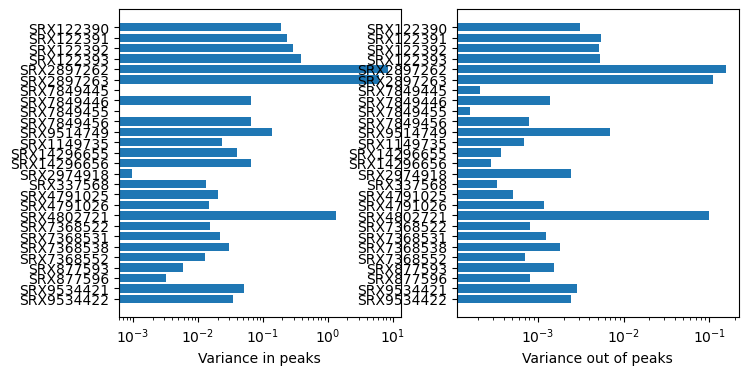

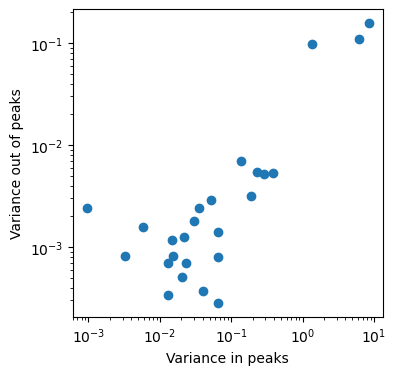

In [35]:
v_in = pd.Series(v_in)
v_out = pd.Series(v_out)

fig, axes = plt.subplots(1,2,figsize=(8,4))
ax = axes[0]
ax.barh(v_in.index,v_in.values)
ax.set_xlabel('Variance in peaks')
ax.invert_yaxis()
ax.set_xscale('log')

ax = axes[1]
ax.barh(v_out.index,v_out.values)
ax.set_xlabel('Variance out of peaks')
ax.invert_yaxis()
ax.set_xscale('log')

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(v_in.values,v_out.values)
ax.set_xlabel('Variance in peaks')
ax.set_ylabel('Variance out of peaks')
ax.set_xscale('log')
ax.set_yscale('log')




In [37]:
v_out

SRX122390      0.003124
SRX122391      0.005454
SRX122392      0.005142
SRX122393      0.005344
SRX2897262     0.156534
SRX2897263     0.110346
SRX7849445     0.000209
SRX7849446     0.001406
SRX7849455     0.000161
SRX7849456     0.000796
SRX9514749     0.006949
SRX1149735     0.000699
SRX14296655    0.000374
SRX14296656    0.000281
SRX2974918     0.002426
SRX337568      0.000336
SRX4791025     0.000507
SRX4791026     0.001179
SRX4802721     0.098151
SRX7368522     0.000820
SRX7368531     0.001239
SRX7368538     0.001805
SRX7368552     0.000702
SRX877593      0.001557
SRX877596      0.000807
SRX9534421     0.002866
SRX9534422     0.002418
dtype: float64